In [1]:
%load_ext autoreload
%autoreload 2


In [75]:
from flowField import *
from flowFieldWavy import *
import h5py
import numpy as np
import pdb
import cProfile
import time
from pseudo import *
from scipy.linalg import norm, svd
from scipy.sparse.linalg import gmres, LinearOperator
from scipy.optimize import newton_krylov,root,anderson
import exactRiblet as rib
import os
import resource

import matplotlib.pyplot as plt
%matplotlib inline

figureFolder = "/home/sabarish/Dropbox/reports/2016/equilibria/figures/"
docFolder = "./doc/figures/"
#%run test_flowFieldWavy.py
resnormFun = lambda x: x.residuals().appendField(x.slice(nd=[0,1,2]).div()).norm()

In [111]:
rib.testExactRibletModule(L=4,M=8,epsArr=np.array([0.,0.]),complexType=np.complex)
rib.testExactRibletModule(complexType=np.complex)

Verifying rib.linr(sigma1=False)...
Verifying rib.jcbn(sigma1=False)...
Verifying rib.linr(sigma1=True)...
Success for all tests!
Verifying rib.linr(sigma1=False)...
Verifying rib.jcbn(sigma1=False)...
Verifying rib.linr(sigma1=True)...
Residual norm for linear with sigma1 is: 0.0180839605066


(True, True, False)

In [142]:
vf = h52ff('testFields/eq1.h5')
pf = h52ff('testFields/pres_eq1.h5',pres=True)
assert isinstance(vf,flowFieldRiblet) and isinstance(pf,flowFieldRiblet)

vf.flowDict['epsArr'] = np.array([0.,0.0])
pf.flowDict['epsArr'] = np.array([0.,0.0])
tol = 1.0e-06

In [166]:
x = loadh5('ribEq1L7M10N30E0000.hdf5')
#x = vf.appendField(pf)
x.flowDict['epsArr'] = np.array([0.,0.,0.01])
#vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf,tol=1.0e-06,complexType=np.complex64)
x0 = x.copy()

# Testing rib.linr(sigma1=True)

In [178]:
x = x0.slice(L=3,M=4)
M = x.nz//2
for lp in range(x.nx):
    l = lp- x.nx//2
    print(l,  'u:', chebnorm(x[0,lp,:M,0] - (-1.)**l * x[0,lp,:M:-1,0], x.N))
    print(l,  'v:', chebnorm(x[0,lp,:M,1] - (-1.)**l * x[0,lp,:M:-1,1], x.N))
    print(l,  'w:', chebnorm(x[0,lp,:M,2] + (-1.)**l * x[0,lp,:M:-1,2], x.N))
    print(l,  'p:', chebnorm(x[0,lp,:M,3] - (-1.)**l * x[0,lp,:M:-1,3], x.N))

x.checkSymms()

-3 u: 2.70487851916e-13
-3 v: 7.81007665823e-14
-3 w: 3.74137371698e-14
-3 p: 1.31674441638e-15
-2 u: 1.45523861496e-12
-2 v: 3.77544050431e-13
-2 w: 2.28750388255e-13
-2 p: 1.62520211505e-14
-1 u: 6.33878837819e-12
-1 v: 1.20463952687e-12
-1 w: 1.87483938138e-12
-1 p: 2.80253228225e-13
0 u: 4.66353853288e-11
0 v: 2.07774876495e-12
0 w: 1.73221665939e-12
0 p: 3.75938386734e-14
1 u: 6.33878760003e-12
1 v: 1.20463489695e-12
1 w: 1.8748402561e-12
1 p: 2.80255061207e-13
2 u: 1.45523525206e-12
2 v: 3.77543645139e-13
2 w: 2.28748841319e-13
2 p: 1.62515379436e-14
3 u: 2.70487084798e-13
3 v: 7.8100504432e-14
3 w: 3.74138249238e-14
3 p: 1.31674766963e-15


{'others': 'Maybe', 'sigma1': True, 'sigma2': True, 'sigma3': True}

In [179]:
x = x0.slice(L=3,M=4,N=7); x.flowDict.update({'eps':0.1, 'epsArr':np.array([0.,0.1])})
Lmat = rib.linr(x.flowDict,sigma1=False)
Lmat1 = rib.linr(x.flowDict,sigma1=True)


In [180]:
N = x.N
xArr = x.copyArray()
L = x.nx//2; L1 = L+1; M = x.nz//2; M1 = M+1; N4 = 4*N
s1 = x.nz*4*N
s2 = M1  *4*N
s3 = s1-s2; 

## Checking if Lmat and Lmat1 relate as they should

In [194]:

for l0 in range(-L,1):
    l = l0; 
    N2 = 2*N
    l0p = l0+L; lp = l+L
    print('l0:',l0)
    for m0 in range(-M,1):
        m0p = m0+M
        for m in range(-M,1):
            mp = m+M; mp_ = M-m  #Index for the negative mode
            # Streamwise equation for m0^th mode, due to +m, but only for u 
            arr01 = Lmat[l0p*s1+m0p*N4: l0p*s1+m0p*N4+N4, lp*s1+mp*N4: lp*s1+mp*N4+N ]
            # Equations for m0^th mode, due to -m
            arr02 = Lmat[l0p*s1+m0p*N4: l0p*s1+m0p*N4+N4, lp*s1+mp_*N4: lp*s1+mp_*N4+N ]


            arr1 = Lmat1[l0p*s2+m0p*N4: l0p*s2 + m0p*N4+N4, lp*s2+mp*N4: lp*s2+mp*N4+N ]

            # arr1 should be arr01 + (-1)^l * arr02
            arr0 = arr01 
            if m != 0:
                arr0 += (-1.)**(lp-L) * arr02
            print('m0:',m0,'m:',m, ' norm:',np.linalg.norm( (arr0-arr1).flatten()  ))

l0: -3
m0: -4 m: -4  norm: 0.0
m0: -4 m: -3  norm: 0.0
m0: -4 m: -2  norm: 0.0
m0: -4 m: -1  norm: 0.0
m0: -4 m: 0  norm: 0.0
m0: -3 m: -4  norm: 0.0
m0: -3 m: -3  norm: 0.0
m0: -3 m: -2  norm: 0.0
m0: -3 m: -1  norm: 0.0
m0: -3 m: 0  norm: 0.0
m0: -2 m: -4  norm: 0.0
m0: -2 m: -3  norm: 0.0
m0: -2 m: -2  norm: 0.0
m0: -2 m: -1  norm: 0.0
m0: -2 m: 0  norm: 0.0
m0: -1 m: -4  norm: 0.0
m0: -1 m: -3  norm: 0.0
m0: -1 m: -2  norm: 0.0
m0: -1 m: -1  norm: 0.0466797493611
m0: -1 m: 0  norm: 0.0
m0: 0 m: -4  norm: 0.0
m0: 0 m: -3  norm: 0.0
m0: 0 m: -2  norm: 0.0466797493611
m0: 0 m: -1  norm: 0.0463790319437
m0: 0 m: 0  norm: 0.0
l0: -2
m0: -4 m: -4  norm: 0.0
m0: -4 m: -3  norm: 0.0
m0: -4 m: -2  norm: 0.0
m0: -4 m: -1  norm: 0.0
m0: -4 m: 0  norm: 0.0
m0: -3 m: -4  norm: 0.0
m0: -3 m: -3  norm: 0.0
m0: -3 m: -2  norm: 0.0
m0: -3 m: -1  norm: 0.0
m0: -3 m: 0  norm: 0.0
m0: -2 m: -4  norm: 0.0
m0: -2 m: -3  norm: 0.0
m0: -2 m: -2  norm: 0.0
m0: -2 m: -1  norm: 0.0
m0: -2 m: 0  norm: 0.0
m0:

In [163]:
lp = 1
linTerm = np.dot(Lmat[lp*s1:lp*s1+s2], xArr[0,:x.nx//2+1].flatten())
linTerm1 = np.dot(Lmat1[lp*s2:(lp+1)*s2], xArr[0,:x.nx//2+1, :x.nz//2+1].flatten())
chebnorm(linTerm - linTerm1, N), s1, s2


(0.0, 60, 40)

In [164]:
linTerm2 = np.dot(Lmat,xArr[0,:L1].flatten())
linTerm2 = linTerm2.reshape((L1, s1))[:,:s2]
linTerm1 = np.dot(Lmat1, xArr[0,:L1, :M1].flatten())

chebnorm(linTerm2.flatten() - linTerm1.flatten(), N), s1, s2


(0.0053930781246858744, 60, 40)

(468, 156)

# Symmetries of Eq1

In [5]:
x0 = loadh5('solutions/ribEq/L7M10/ribEq1L7M10N30E0000.hdf5')
x5 = loadh5('solutions/ribEq/L7M10/ribEq1L7M10N30E0500.hdf5')

def verifySyms(x, l0=None,l1=None, m0=None, m1=None, tol = 1.0e-09):
    L = x.nx//2; M = x.nz//2
    if l0 is None: l0 = -L
    if l1 is None: l1 = L
    if m0 is None: m0 = -M
    if m1 is None: m1 = M
    errFlag = 0
    for l in range(l0,l1):
        for m in range(m0,m1):
            # Verify symmetry in u,v:
            uvErr = np.linalg.norm( (x[0, L+l, M+m,:2] - ((-1.)**l) * x[0, L+l, M-m,:2]).flatten()  )
            if uvErr > tol: 
                errFlag = 1
                warn(
                "Symmetry $\\sigma_1$ is not satisfied by u and/or v mode (%d,%d). Error is %.3g"%(l,m,uvErr))
            # Verify symmetry in w:
            wErr = np.linalg.norm( (x[0, L+l, M+m,2] + ((-1.)**l) * x[0, L+l, M-m,2]).flatten()  )
            if wErr > tol: 
                errFlag = 1
                warn(
                "Symmetry $\\sigma_1$ is not satisfied by w for mode (%d,%d). Error is %.3g"%(l,m,wErr))
    if not errFlag:
        print("Symmetry $\\sigma_1$ is satisfied for all Fourier modes of x")

In [6]:
verifySyms(x0, tol=1.0e-10)

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:18: UserWarning: Symmetry $\sigma_1$ is not satisfied by u and/or v mode (0,-1). Error is 1.46e-10
/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:18: UserWarning: Symmetry $\sigma_1$ is not satisfied by u and/or v mode (0,1). Error is 1.46e-10


# Validating solver with laminar flows

In [9]:
flowDict = getDefaultDict()
flowDict.update({'L':1, 'M':6,'N':30,'alpha':5.,'beta':10.,'eps':0.05,'epsArr':np.array([0.,0.05]),'Re':100.,'isPois':0})

start = time.time()
for k in range(3):
    vf = flowFieldRiblet(flowDict=flowDict).view4d()
    vf[0,vf.nx//2,vf.nz//2,0] = vf.y
    pf = vf.getScalar().zero()

    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf,doLineSearch=False,rcond=1.0e-07)
print('runTime(s):',time.time()-start)
vf0 = vf.copy(); pf0 = pf.copy()

Initial residual norm is 0.0707
Starting iterations...............
iter: 1
Jacobian inversion success with residual norm  2.96800245451e-14
residual norm before setSymms: 1.47171199884e-13
Residual norm after setSymms in 1 th iteration is 1.47e-13
Converged in  1  iterations. Returning....................................
Initial residual norm is 0.0707
Starting iterations...............
iter: 1
Jacobian inversion success with residual norm  2.96800245451e-14
residual norm before setSymms: 1.47171199884e-13
Residual norm after setSymms in 1 th iteration is 1.47e-13
Converged in  1  iterations. Returning....................................
Initial residual norm is 0.0707
Starting iterations...............
iter: 1
Jacobian inversion success with residual norm  2.96800245451e-14
residual norm before setSymms: 1.47171199884e-13
Residual norm after setSymms in 1 th iteration is 1.47e-13
Converged in  1  iterations. Returning....................................
runTime(s): 174.1941900253296


0.0

# Plots for JFMrapids

## Residual norms, accuracy, energy density, bulk dissipation rate

In [3]:
#%%%%%%%%%%%%%%%%%%%%
# eps_1

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e1/'
nSol = 21 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][1]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

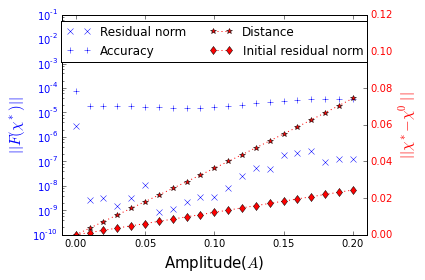

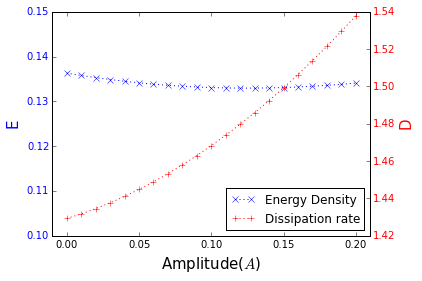

In [4]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.21])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.21])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE1.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.21])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.21])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE1.eps',format='eps',dpi=1200)
plt.show()


In [5]:
#%%%%%%%%%%%%%%%%%%%%
# eps_2

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e2/'
nSol = 11 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][2]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

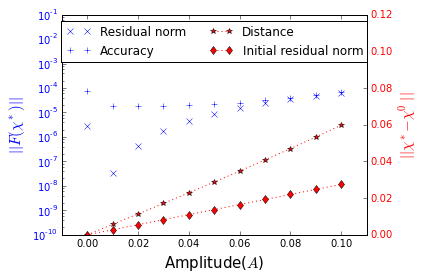

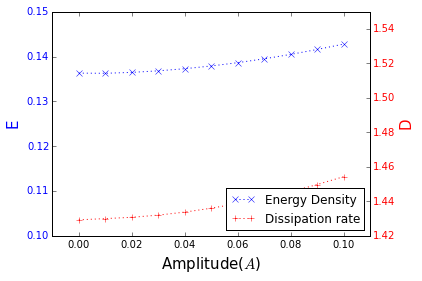

In [9]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE2.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([1.42,1.55])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE2.eps',format='eps',dpi=1200)
plt.show()


In [10]:
#%%%%%%%%%%%%%%%%%%%%
# eps_3

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e3/'
nSol = 11 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][3]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

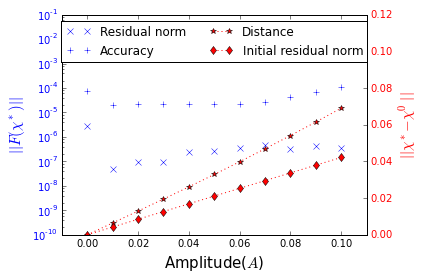

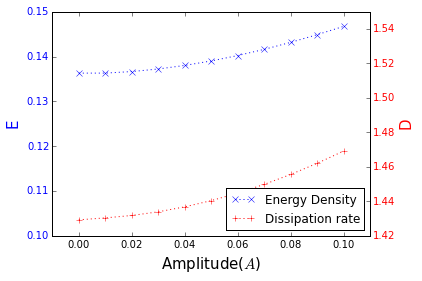

In [11]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE3.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([1.42,1.55])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE3.eps',format='eps',dpi=1200)
plt.show()


## Phase-difference

In [13]:
# eps_1 = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A05/ribEq1L7M16N35E1_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        



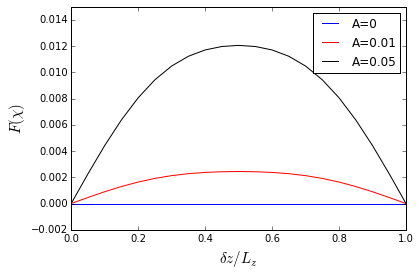

In [14]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE1.eps',format='eps',dpi=1200)
plt.show()

In [20]:
#%%%%%%%%%%%%%%%
# eps_2
#%%%%%%%%%%%%%%%%
# eps_q = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e2/A05/ribEq1L7M16N35E1_001E2_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))    


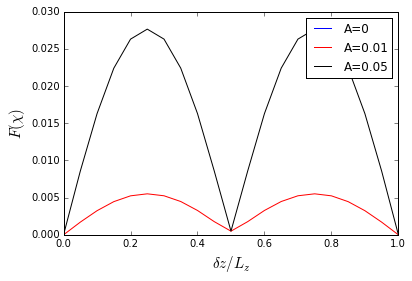

In [21]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
#plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE2.eps',format='eps',dpi=1200)
plt.show()

In [17]:
#%%%%%%%%%%%%%%%
# eps_3
#%%%%%%%%%%%%%%%%
# eps_q = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e3/A05/ribEq1L7M16N35E1_001E2_000E3_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        



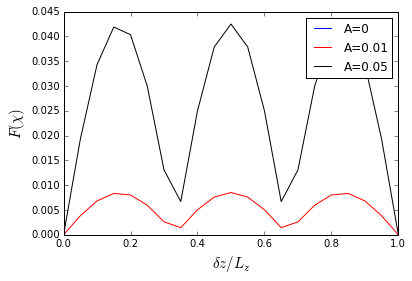

In [19]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
#plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE3.eps',format='eps',dpi=1200)
plt.show()

## Velocity plots

Phase-shifted Eq1 at x0, with A=0, fnorm=6.41e-05


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


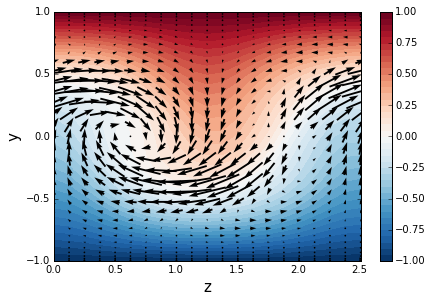

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


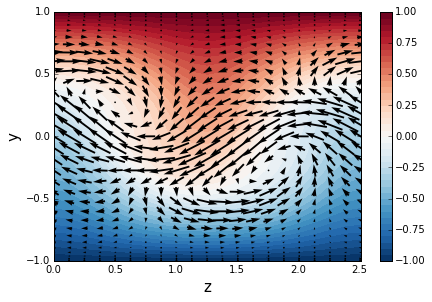

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


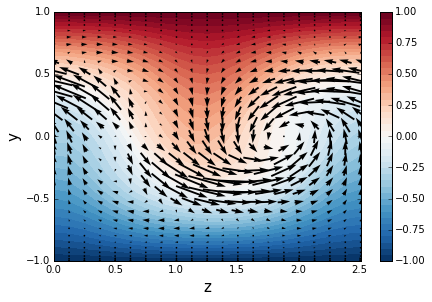

Phase-shifted Eq1 at x0, with A=0.01, fnorm=1.11e-08


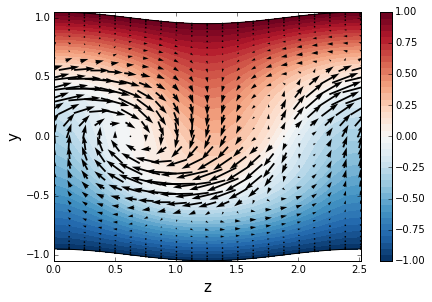

Phase-shifted Eq1 at x1, with A=0.01, fnorm=1.11e-08


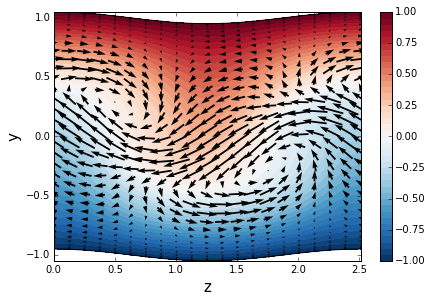

Phase-shifted Eq1 at x1, with A=0.01, fnorm=1.11e-08


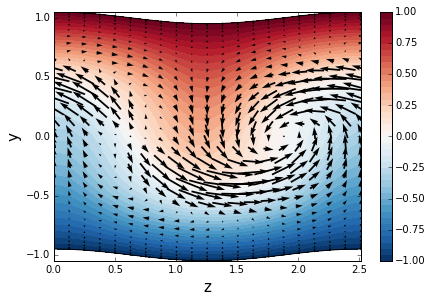

Phase-shifted Eq1 at x0, with A=0.02, fnorm=3.46e-09


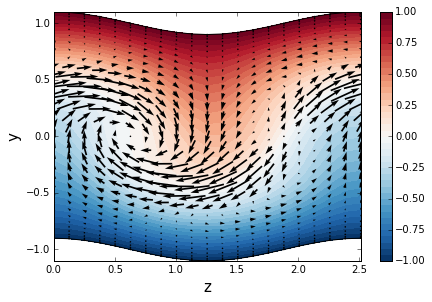

Phase-shifted Eq1 at x1, with A=0.02, fnorm=3.46e-09


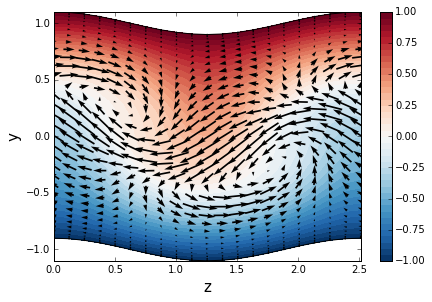

Phase-shifted Eq1 at x1, with A=0.02, fnorm=3.46e-09


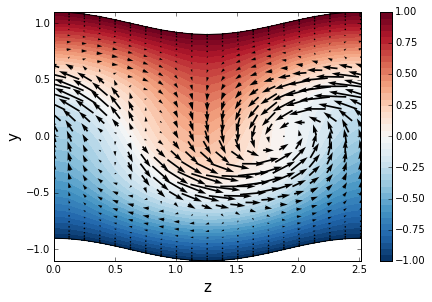

Phase-shifted Eq1 at x0, with A=0.03, fnorm=1.84e-07


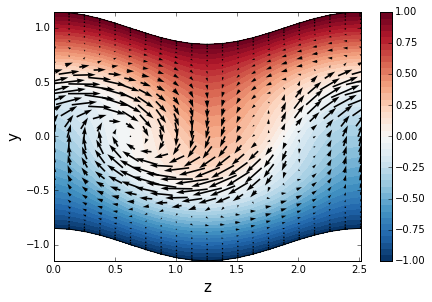

Phase-shifted Eq1 at x1, with A=0.03, fnorm=1.84e-07


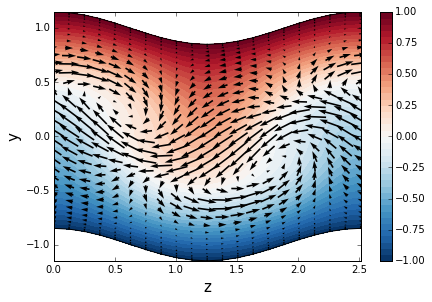

Phase-shifted Eq1 at x1, with A=0.03, fnorm=1.84e-07


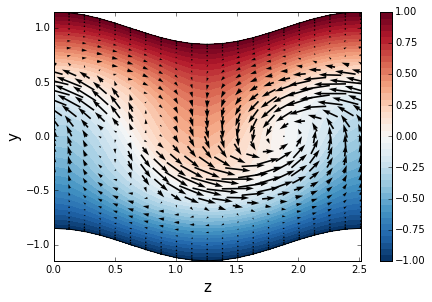

In [41]:
loadPath = 'solutions/e1/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_050.hdf5'))
xList.append(loadh5(loadPath+'A15/ribEq1L7M16N35E1_075.hdf5'))
fNameList = ['A00','A05','A10','A15']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b; eps = vf.flowDict['eps']; A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE1_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


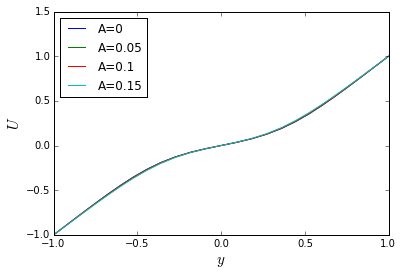

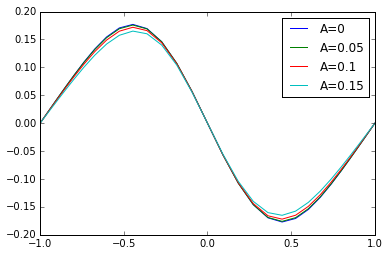

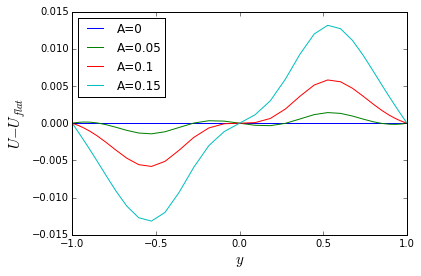

In [42]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE1.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE1.eps',format='eps',dpi=1200)
plt.show()

Phase-shifted Eq1 at x0, with A=0, fnorm=6.41e-05


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


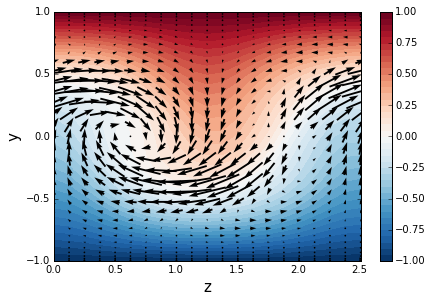

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


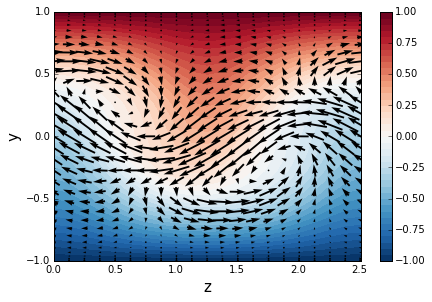

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


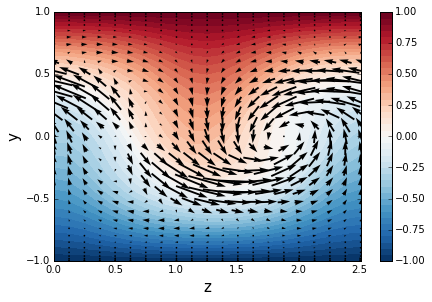

Phase-shifted Eq1 at x0, with A=0.01, fnorm=8.83e-06


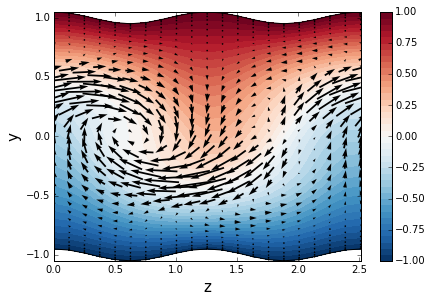

Phase-shifted Eq1 at x1, with A=0.01, fnorm=8.83e-06


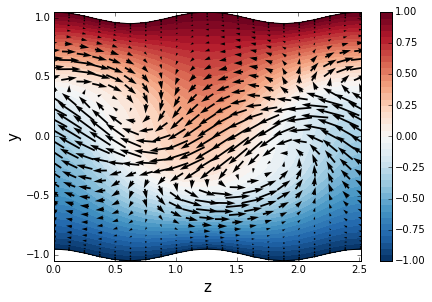

Phase-shifted Eq1 at x1, with A=0.01, fnorm=8.83e-06


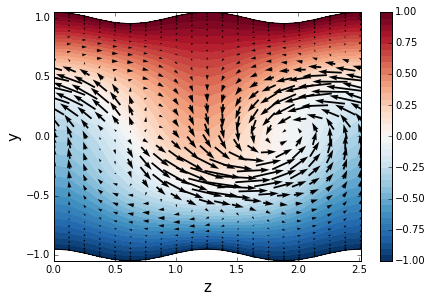

Phase-shifted Eq1 at x0, with A=0.02, fnorm=6.32e-05


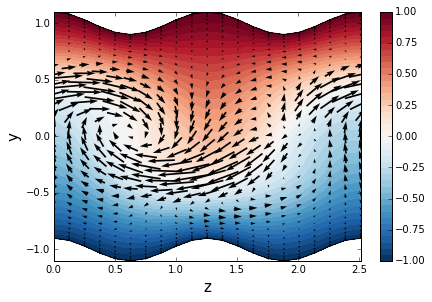

Phase-shifted Eq1 at x1, with A=0.02, fnorm=6.32e-05


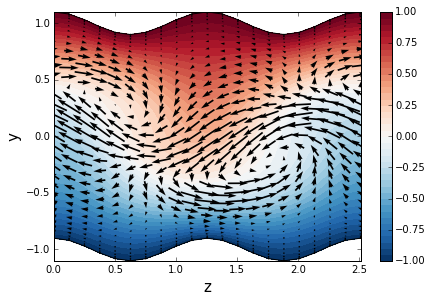

Phase-shifted Eq1 at x1, with A=0.02, fnorm=6.32e-05


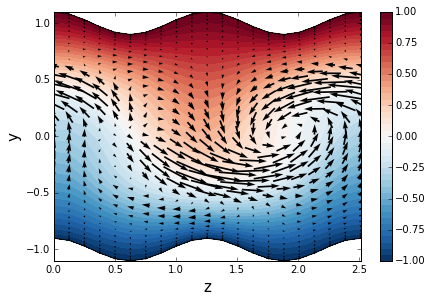

In [39]:
#%%%%%%%%%%%%%%%%%%%%%
# eps_2
#%%%%%%%%%%%%%%%%%%%%%%%
loadPath = 'solutions/e2/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_001E2_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_001E2_050.hdf5'))
fNameList = ['A00','A05','A10']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b; 
    if k > 0:
        eps = vf.flowDict['epsArr'][2]
    else: 
        eps = 0.
    A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(2.*b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE2_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


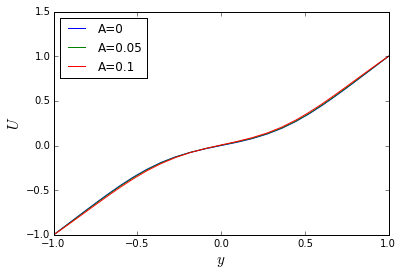

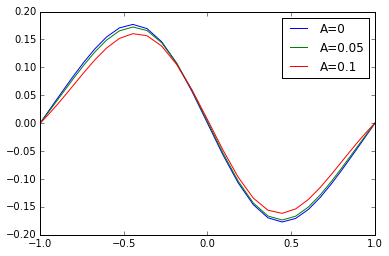

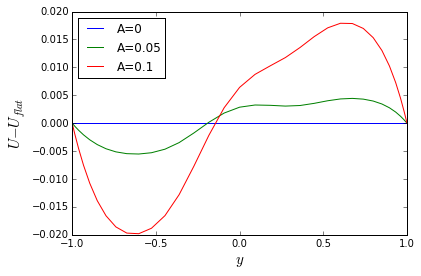

In [40]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE2.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE2.eps',format='eps',dpi=1200)
plt.show()

Phase-shifted Eq1 at x0, with A=0, fnorm=4.05e-12


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


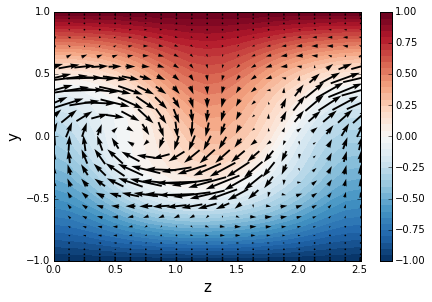

Phase-shifted Eq1 at x1, with A=0, fnorm=4.05e-12


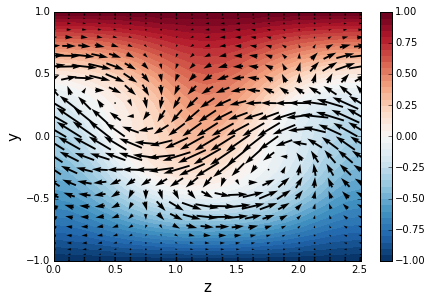

Phase-shifted Eq1 at x1, with A=0, fnorm=4.05e-12


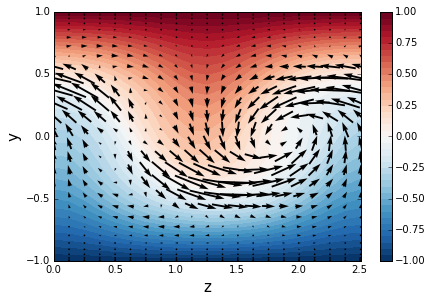

Phase-shifted Eq1 at x0, with A=0.01, fnorm=2.77e-07


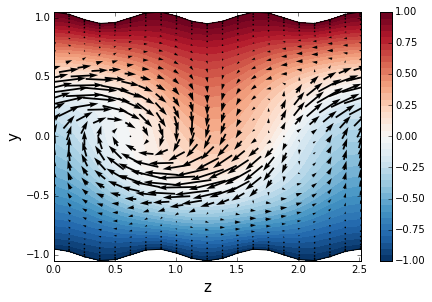

Phase-shifted Eq1 at x1, with A=0.01, fnorm=2.77e-07


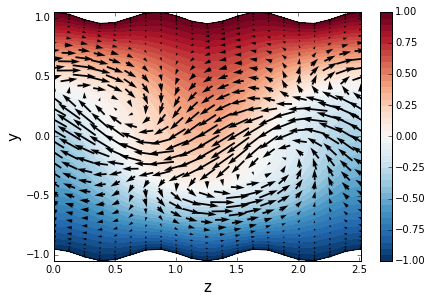

Phase-shifted Eq1 at x1, with A=0.01, fnorm=2.77e-07


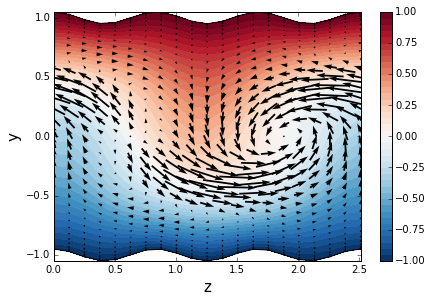

Phase-shifted Eq1 at x0, with A=0.02, fnorm=3.55e-07


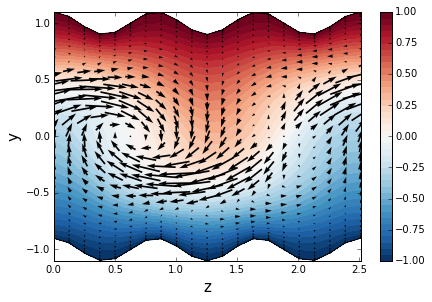

Phase-shifted Eq1 at x1, with A=0.02, fnorm=3.55e-07


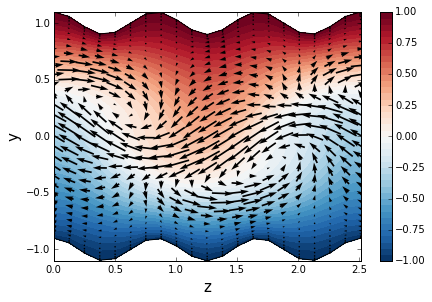

Phase-shifted Eq1 at x1, with A=0.02, fnorm=3.55e-07


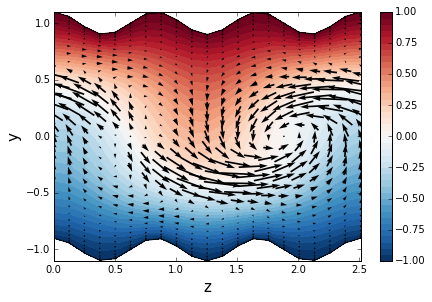

In [34]:
#%%%%%%%%%%%%%
# eps_3
#%%%%%%%%%%%%%%%%
loadPath = 'solutions/e3/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_001E2_000E3_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_001E2_000E3_050.hdf5'))
fNameList = ['A00','A05','A10']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b
    if k > 0:
        eps = vf.flowDict['epsArr'][3]
    else: 
        eps = 0.
    A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(3.*b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE3_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


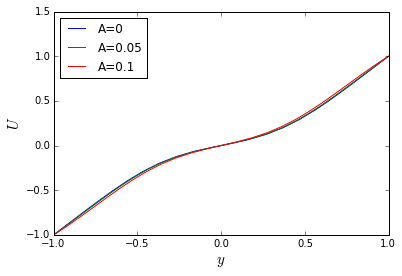

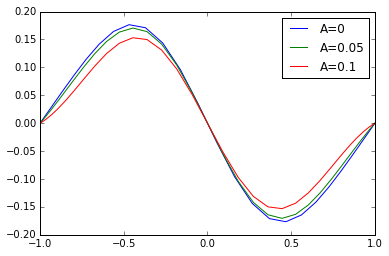

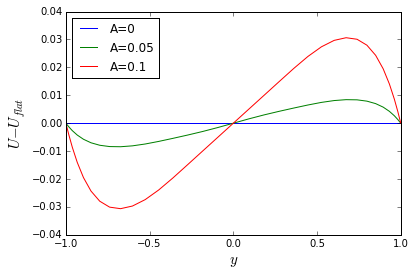

In [37]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE3.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE3.eps',format='eps',dpi=1200)
plt.show()

## Direction of perturbation from flat-walled solution

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


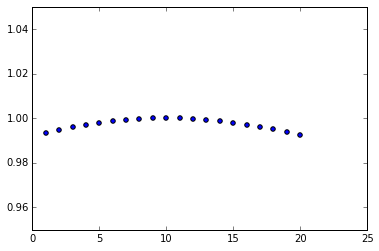

In [83]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
x1 = loadh5('solutions/e1/A10/ribEq1L7M16N35E1_050.hdf5')
dx1 = x1 - x0

nSol = 21
direcScalar = np.zeros(nSol)

for k in range(1,nSol):
    loadPath = 'solutions/e1/'
    fName = 'A%02d/ribEq1L7M16N35E1_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    
    dx = x-x0
    direcScalar[k] = dx.dot(dx1)/dx.norm()/dx1.norm()

plt.scatter(np.arange(1,nSol),direcScalar[1:])
plt.ylim([0.95, 1.05])
plt.show()


/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


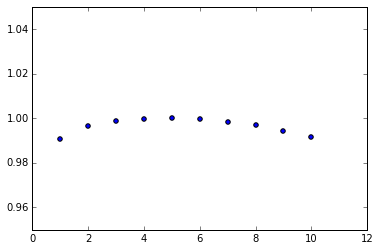

In [84]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
x1 = loadh5('solutions/e2/A05/ribEq1L7M16N35E1_001E2_025.hdf5')
dx1 = x1 - x0

nSol = 11
direcScalar = np.zeros(nSol)

for k in range(1,nSol):
    loadPath = 'solutions/e2/'
    fName = 'A%02d/ribEq1L7M16N35E1_001E2_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    
    dx = x-x0
    direcScalar[k] = dx.dot(dx1)/dx.norm()/dx1.norm()

plt.scatter(np.arange(1,nSol),direcScalar[1:])
plt.ylim([0.95, 1.05])
plt.show()


In [ ]:
epsArr = 0.5*np.arange(0.01,0.1001,0.01)

flowDict = getDefaultDict()
flowDict.update({'L':0, 'M':7,'N':35,'nd':3})
vf0 = flowFieldRiblet(flowDict=flowDict.copy())
vf0[0, vf0.nx//2, vf0.nz//2, 0] = vf0.y

# eps_1
for eps in epsArr:
    print('Iterating for eps_1 =',eps)
    vf = vf0.copy()
    vf.flowDict.update({'eps':eps,'epsArr':np.array([0., eps])})
    pf = vf.getScalar().zero()
    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
    x = vf.appendField(pf)
    x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')
    
# eps_2
for eps in epsArr:
    print('Iterating for eps_2 =',eps)
    vf = vf0.copy()
    vf.flowDict.update({'eps':0.001,'epsArr':np.array([0.,0.001, eps])})
    pf = vf.getScalar().zero()
    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
    x = vf.appendField(pf)
    x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')

    
# eps_3
for eps in epsArr:
    print('Iterating for eps_3 =',eps)
    vf = vf0.copy()
    vf.flowDict.update({'eps':0.001,'epsArr':np.array([0.,0.001,0., eps])})
    pf = vf.getScalar().zero()
    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
    x = vf.appendField(pf)
    x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')

    

Iterating for eps_1 = 0.005
Initial residual norm is 0.00011
Starting iterations...............
iter: 1
